### Import modules and define methods

In [1]:
%reload_ext autoreload
%autoreload 2

from preprocess import *
from argparse import Namespace

import matplotlib.pyplot as plt
plt.set_cmap('gray')

metadata={}

def show_img(img, title='', axis=False, vmin=None, vmax=None):
    imshow_args = {}
    
    if vmin:
        imshow_args['vmin'] = vmin
    if vmax:
        imshow_args['vmax'] = vmax
    
    im_axis = 'on' if axis else 'off'
    plt.axis(im_axis)
    plt.imshow(img, **imshow_args)
    plt.title(title, fontsize=15)

def show_gad_comparison(img_pre, img_low, img_post):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 3, 1)
    show_img(img_pre, title='Pre contrast')

    fig.add_subplot(1, 3, 2)
    show_img(img_low, title='10% dosage')

    fig.add_subplot(1, 3, 3)
    show_img(img_post, title='Full dosage')

    plt.show()

def show_comparison(img1, img2, titles=['', ''], vmin=None, vmax=None):
    fig = plt.figure(figsize=(15, 10))
    fig.tight_layout()

    fig.add_subplot(1, 2, 1)
    show_img(img1, title=titles[0], vmin=vmin, vmax=vmax)

    fig.add_subplot(1, 2, 2)
    show_img(img2, title=titles[1], vmin=vmin, vmax=vmax)
    
    plt.show()

def iminfo(img):
    print(img.shape, img.dtype, img.min(), img.max(), img.mean())

def diff_img(img1, img2):
    return np.abs(np.subtract(img1.astype(np.float32), img2.astype(np.float32))).astype(np.float32)

Using TensorFlow backend.


### Initialize dummpy argparse Namespace

In [2]:
args = Namespace(
    path_base='/home/srivathsa/projects/studies/gad/tiantan/NO23', verbose=True,
    output='/home/srivathsa/projects/studies/gad/tiantan_pp/data/NO23.h5',
    discard_start_percent=0, discard_end_percent=0, normalize=True,
    normalize_fun='mean', transform_type='rigid', scale_matching=True,
    path_zero=None, path_low=None, path_full=None, mask_threshold=0.08,
    override=False, skip_mask=False, scale_dicom_tags=False, skip_scale_im=False,
    skip_registration=False, nslices=20, joint_normalize=False, global_scale_ref_im0=False
)

### Fetch original images

In [3]:
ims, hdr, metadata = get_images(args, metadata)

path_zero = /home/srivathsa/projects/studies/gad/tiantan/NO23/3DT1WMPRAGE_SAG_CS4_301
path_low = /home/srivathsa/projects/studies/gad/tiantan/NO23/3DT1WMPRAGE_SAG_CS4_601
path_full = /home/srivathsa/projects/studies/gad/tiantan/NO23/3DT1WMPRAGE_SAG_CS4_701
image sizes:  (196, 240, 240) (196, 240, 240) (196, 240, 240)


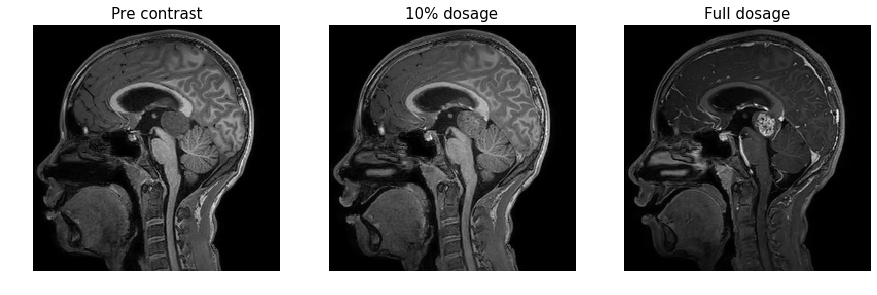

In [4]:
show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])

### Mask images

In [5]:
ims, mask, metadata = mask_images(args, ims, metadata)

masking


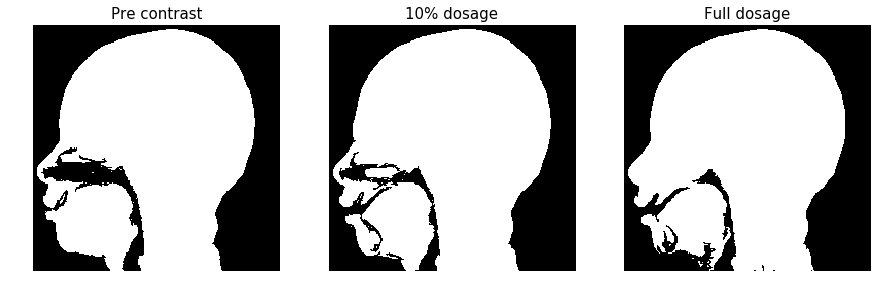

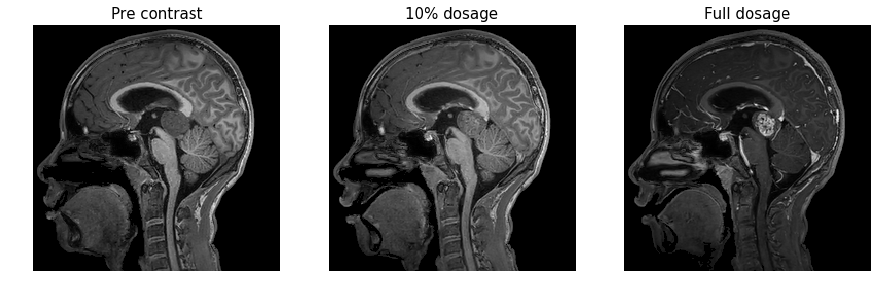

In [6]:
show_gad_comparison(mask[96, 0], mask[96, 1], mask[96, 2])
show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])

### Scale DICOM slope and intercept

In [7]:
ims, metadata = dicom_scaling(args, ims, hdr, metadata)

(240, 240) float32 0.0 532.0 90.7834
(240, 240) float32 0.0 569.0 105.0512
(240, 240) float32 0.0 1339.0 150.54512


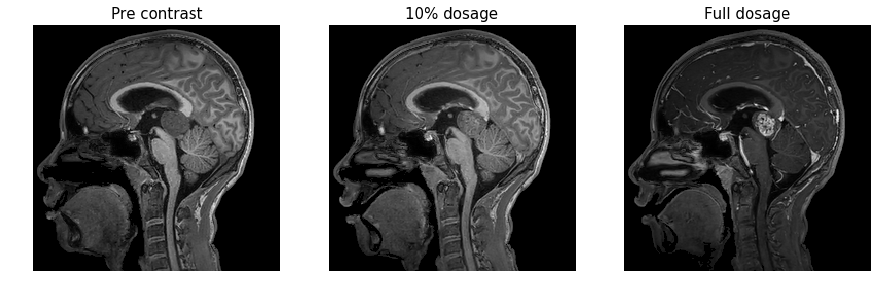

In [8]:
iminfo(ims[96, 0])
iminfo(ims[96, 1])
iminfo(ims[96, 2])

show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])

### Histogram normalization

In [9]:
ims, metadata = hist_norm(args, ims, metadata)

image intensity normalization
scaling done, 1.05 s
image intensity normalization
scaling done, 0.98 s


(240, 240) float32 0.0 532.0 90.7834
(240, 240) float32 0.0 520.92175 95.823044
(240, 240) float32 0.0 673.9049 99.58


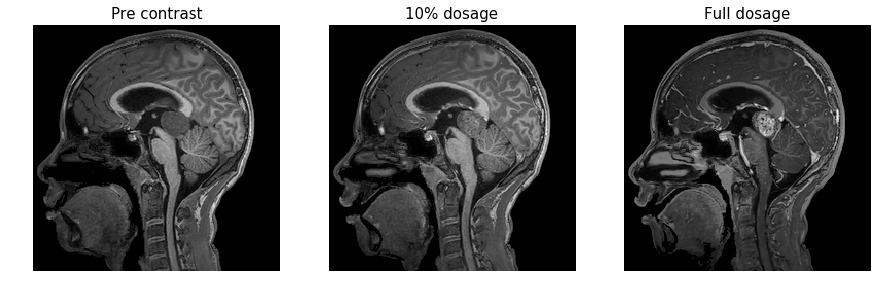

In [10]:
iminfo(ims[96, 0])
iminfo(ims[96, 1])
iminfo(ims[96, 2])

show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])

### Image registration

In [11]:
ims, metadata = register(args, ims, metadata)

image registration
registration done, 12.6 s
low dose transform parameters: ('-0.00170243', '-0.00382217', '-0.00574285', '0.169041', '-0.170509', '-0.222291')
image registration
registration done, 13.9 s
full dose transform parameters: ('-0.00929679', '-0.00359681', '-0.00824484', '0.139793', '0.070881', '-0.451085')


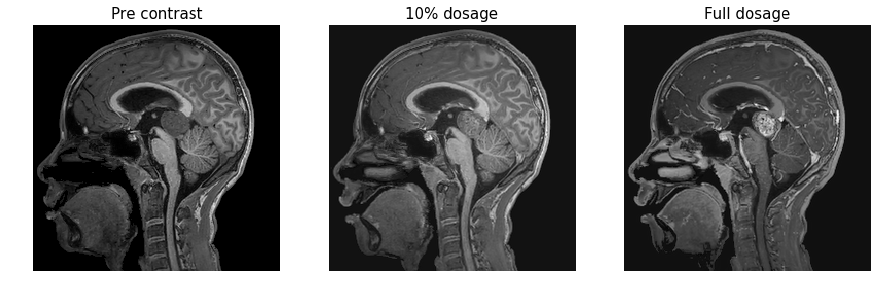

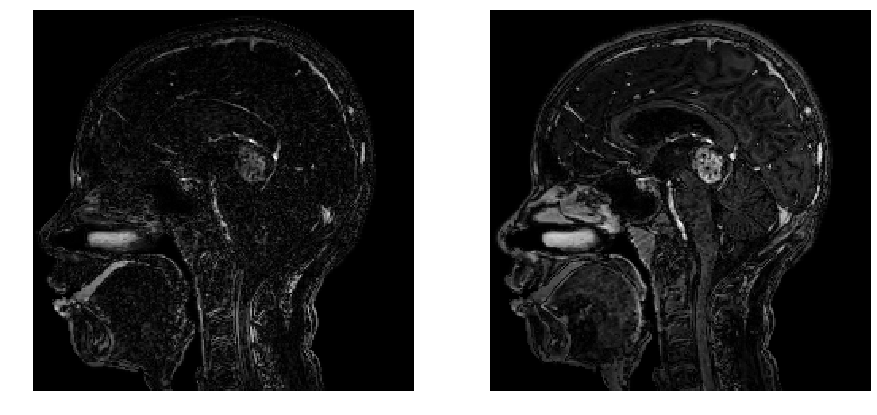

In [12]:
show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])
show_comparison(diff_img(ims[96, 0], ims[96, 1]), diff_img(ims[96, 0], ims[96, 2]))

### Zoom

In [13]:
args.zoom = 512
args.zoom_order = 3

ims_zoom, metadata = zoom_process(args, ims, metadata)

zooming to 512
zoom 0
zoom 0 done: 20.242982387542725 s
zoom 1
zoom 1 done: 21.055075883865356 s
zoom 2
zoom 2 done: 20.568635940551758 s
(196, 3, 512, 512)


(196, 3, 512, 512) float32 -65.18555 711.56256 58.20119


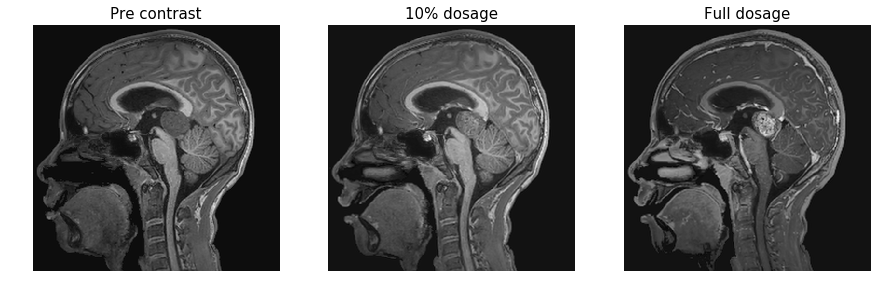

In [14]:
iminfo(ims_zoom)
show_gad_comparison(ims_zoom[96, 0], ims_zoom[96, 1], ims_zoom[96, 2])

### Match scales and global normalization

In [15]:
ims, ims_mod, metadata = prescale_process(args, ims, mask, metadata)
ims, ims_mod, metadata = match_scales(args, ims, ims_mod, metadata)
ims, metadata = global_norm(args, ims, ims_mod, metadata)

intensity before scaling:
mean [148.72443 155.04106 160.59453]
median [143.      148.35495 149.82164]
max [607.      603.91156 686.8405 ]
scale low: 0.9721390790930337
scale full: 0.9721390790930337
done scaling data (0.77 s)
intensity after scaling:
mean [148.72443 150.72105 156.11937]
median [143.      144.22165 145.64746]
max [607.      587.086   667.70447]
normalizing with function  mean <function mean at 0x7f0448114048>
intensity before global scaling:
mean [148.72443 150.6912  156.02441]
median [143.      144.22165 145.64746]
max [607.      587.086   667.70447]
global scaling: [[148.72443 150.6912  156.02441]]
done (0.09s)
intensity after global scaling:
mean [0.99999255 0.9999693  0.99999315]
median [0.9615098  0.95706755 0.93349147]
max [4.081374  3.8959544 4.279487 ]


(240, 240) float32 0.0 3.5770855 0.61041355
(240, 240) float32 -0.2561719 3.3352993 0.61881167
(240, 240) float32 -0.28425276 4.007104 0.61839503


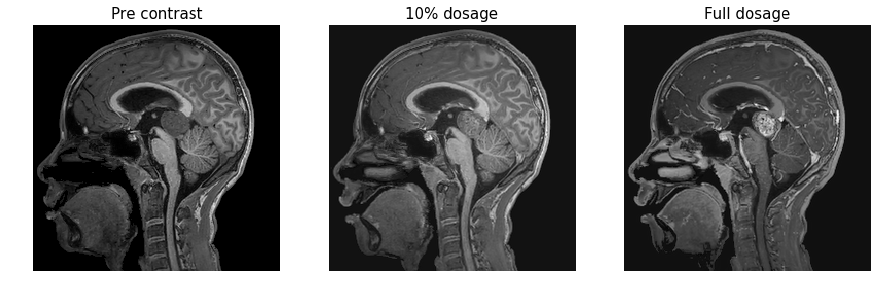

In [16]:
iminfo(ims[96, 0])
iminfo(ims[96, 1])
iminfo(ims[96, 2])

show_gad_comparison(ims[96, 0], ims[96, 1], ims[96, 2])